In [30]:
import numpy as np
from astropy.constants import R_sun, M_sun, G, k_B, m_p
import astropy.units as u

from funcs.model import calculate_specific_flare_flux, calculate_angular_radius

def get_frac_area(radius):
    return np.sin(radius / 180 * np.pi / 2.)**2


import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

# 10kK assumption

In [2]:
k_B

<<class 'astropy.constants.codata2018.CODATA2018'> name='Boltzmann constant' value=1.380649e-23 uncertainty=0.0 unit='J / K' reference='CODATA 2018'>

In [3]:
calculate_specific_flare_flux("TESS", flaret=7e3)

<Quantity 3.57701096e+10 erg / (cm2 s)>

In [4]:
a = 1.
qlum = 1e29 * u.erg / u.s
R = .5 * R_sun
Teff = np.linspace(5e3,5e4,20)
Fth = [calculate_specific_flare_flux("TESS", flaret=t) for t in Teff]
radius = [calculate_angular_radius(fth, a, qlum, R) for fth in Fth]
fill_factor = get_frac_area(np.array(radius)) * 4.

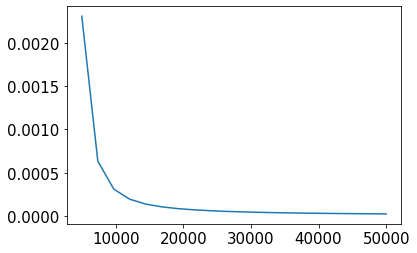

In [5]:
plt.plot(Teff, fill_factor)
#plt.yscale("log")

In [6]:
fill_factor

array([2.31087928e-03, 6.33670568e-04, 3.08814278e-04, 1.92164945e-04,
       1.35977478e-04, 1.03931929e-04, 8.35604071e-05, 6.96014625e-05,
       5.94993948e-05, 5.18794461e-05, 4.59426404e-05, 4.11956193e-05,
       3.73185269e-05, 3.40955297e-05, 3.13760390e-05, 2.90519726e-05,
       2.70438507e-05, 2.52919845e-05, 2.37507160e-05, 2.23845484e-05])

In [27]:
(1e-7 / u.s * np.pi * 2).to("1/d")

<Quantity 0.05428672 1 / d>

In [28]:
2piR/P = vsini / sin i

sin i = vsini * P / 2piR

SyntaxError: invalid syntax (<ipython-input-28-b2ec6745cc59>, line 1)

# back of the envelope calculation: pressure scale height

In [25]:
M = 0.16
Teff = 3030. * u.K
R =  0.199
g = G * (M * M_sun) / (R * R_sun)**2

In [26]:
H = k_B * Teff / (m_p * g)

In [27]:
H.decompose()

<Quantity 22575.98298498 m>

In [19]:
H.decompose()

<Quantity 13837.89950645 m>

In [20]:
13.8 / 180. #M6

0.07666666666666667

In [24]:
9.5 / 180. #L1

0.05277777777777778

In [28]:
22.6 / 180. #M5

0.12555555555555556

The pressure scale heights of the stars in our sample are about $5-13 \%$ of the solar

In [32]:
print(22.6 / (.199 * R_sun), 9.5 / (.107 * R_sun), 180. / (1. * R_sun) )

1.6324254591918916e-07 1 / m 1.2761973081640357e-07 1 / m 2.58732212160414e-07 1 / m


In [36]:
1.63 / 2.59, 1.28/2.59

(0.6293436293436293, 0.4942084942084942)

The relative height of atmospheres on M5-L1 dwarfs is $50-63\%$ percent of the relative solar height.

# latitude vs. flux

In [31]:
from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve
import os
CWD = "/".join(os.getcwd().split("/")[:-2])
import pandas as pd


# Plot stuff
from funcs.model import full_model, aflare_decoupled

In [190]:
# Datasets we analysed
datasets = [#(100004076, "", "03_10_2020_11_27"),
            (237880881, "a", "03_10_2020_11_29"),
            (237880881, "b", "03_10_2020_11_29"),
            (277539431, "", "03_10_2020_11_30"),
             (44984200, "a", "04_08_2020_13_40"),
             (44984200, "b", "04_08_2020_13_40"),
             (44984200, "", "02_08_2020_17_44"),
            ]

In [42]:
res= pd.read_csv(f"{CWD}/analysis/results/mcmc/06_11_2020_mcmcoutput.csv").loc[:6]
res.suffix = res.suffix.fillna("").astype(str)
vals = list(res.columns.values)
vals.remove("suffix")
vals.remove("tstamp")
vals.remove("color")
vals.remove("linestyle")
vals.remove("ID")
#vals.remove("note")
res[vals] = res[vals].astype(float) 

In [37]:
est = {}
plt.figure(figsize=(10,10))
for j, row in res.iterrows():
  
    # Get data
    #df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{row.tstamp}_{row.ID}{row.suffix}_converted_mcmc_sample.csv")
    lc = pd.read_csv(f"{CWD}/data/lcs/{row.tstamp}_{row.ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(row.ID)].iloc[0]
 
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits_decoupled.csv")
    inits = inits[(inits.ID == str(row.ID)+row.suffix) & (inits.tstamp==row.tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun
    
     # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    #inds = np.random.randint(df.shape[0], size=N)


    a = row.a_50
    phi_a = (row.t0_d_50 -lc.t[0]) / target.Prot_d * 2 * np.pi 
    #theta_a = row.latitude_deg_50 / 180 * np.pi
    fwhm1 = row.fwhm1_d_50 / target.Prot_d * 2 * np.pi
    fwhm2 = row.fwhm2_d_50 / target.Prot_d * 2 * np.pi
    print("FWHM", fwhm1, row.fwhm1_d_50, fwhm1/a)
    #i = row.i_deg_50 / 180 * np.pi
    i = np.pi/2

    phi0 = phi_a%(2.*np.pi) - (row.phase_deg_50  / 180 * np.pi)
    flare = aflare_decoupled(phi, phi_a, (fwhm1, fwhm2), a*median)+ median
    print(f"ID: {row.ID}\n")
    est[str(row.ID) + row.suffix] = {}
    for theta_a in np.arange(0.1,89.9,2): 
        th = theta_a / 180. * np.pi
        fullmodel = full_model(phi_a, th, a, fwhm1, fwhm2, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        
        est[str(row.ID) + row.suffix][theta_a] = ED * qlum.value
            
#         if (str(row.ID) == "237880881") & (str(row.suffix) == "a"):
#             if theta_a > 50:
#                 c = "g"
#             else:
#                 c = "grey"
#             plt.plot(flc.time, flc.detrended_flux, c=c, alpha=.3)
            

FWHM 0.8933740166606852 0.02502454077752804 2.55292675500409
ID: 452922110

FWHM 2.978224506651166 0.09005983885548133 2.8391870813516493
ID: 277539431

FWHM 0.2244042965013797 0.01254491238003793 0.09281182739648845
ID: 237880881

FWHM 0.8062096862241817 0.04506968017681448 1.3820526722622821
ID: 237880881

FWHM 0.5863573986682548 0.01054534966107104 0.9801187047748269
ID: 44984200

FWHM 0.9525977306083406 0.01713200204930162 18.572317537358643
ID: 44984200



<Figure size 720x720 with 0 Axes>

In [214]:
print(Fth)

90616356361.5605 erg / (cm2 s)


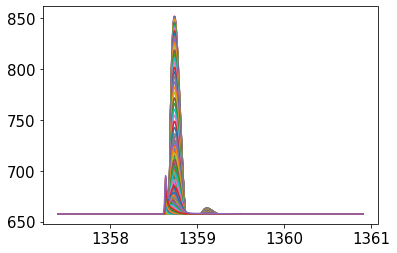

In [159]:
sim = {}
# time = 
# phi = 
# qlum = 
# Fth =
# R =
# median =
# i = 
for theta_a in np.arange(.1,89.9,2): 
    sim[theta_a] = {}
    th = theta_a / 180. * np.pi
    for wiggle in [0.05, .1,.2,.25,.4,.5, 1.,2.,60., 120.]:#np.arange(.2,6.5,.5):
        awiggle = wiggle #/ 180. * np.pi
        fullmodel = full_model(21., th, 3., awiggle, i, phi0=phi0,
                           phi=phi, num_pts=50, qlum=qlum,
                           Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        sim[theta_a][wiggle] = ED * qlum.value
        if wiggle < 2.:
            plt.plot(time, fullmodel)

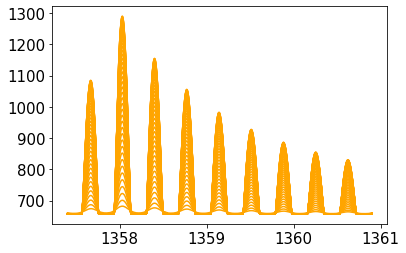

In [174]:
sim = {}
# time = 
# phi = 
# qlum = 
# Fth =
# R =
# median =
# i = 
for theta_a in np.arange(.1,89.9,2): 
    sim[theta_a] = {}
    th = theta_a / 180. * np.pi
    for wiggle, phia in [(0.15, 20.), (60.,10.)]:#np.arange(.2,6.5,.5):
        awiggle = wiggle #/ 180. * np.pi
        fullmodel = full_model(phia, th, 1., awiggle, i, phi0=phi0,
                           phi=phi, num_pts=50, qlum=qlum,
                           Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        sim[theta_a][wiggle] = ED * qlum.value
        if phia==10.:

            plt.plot(time, fullmodel, c=c)

In [175]:
simdf = pd.DataFrame(sim).T

simdf2 = simdf/simdf.loc[.1]


,0.15,60.00
0.1,1.000000,1.000000
2.1,0.999363,0.999349
4.1,0.997538,0.997483
6.1,0.994527,0.994405
8.1,0.990333,0.990118
10.1,0.984962,0.984627
12.1,0.978420,0.977940
14.1,0.970715,0.970064
16.1,0.961857,0.961010
18.1,0.951862,0.950788


In [38]:
# reform = {(outerKey, innerKey): values for outerKey, 
#           innerDict in est.items() for innerKey, 
#           values in innerDict.items()}
esti = pd.DataFrame(est)
esti

,452922110,277539431,237880881a,237880881b,44984200a,44984200b
0.1,1.208636e+33,4.315862e+33,6.234814e+32,8.409261e+33,9.179427e+32,1.306950e+32
2.1,1.207861e+33,4.316088e+33,6.211639e+32,8.405031e+33,9.173562e+32,1.306086e+32
4.1,1.205619e+33,4.308711e+33,6.232670e+32,8.387234e+33,9.156546e+32,1.303631e+32
6.1,1.201912e+33,4.291480e+33,6.197335e+32,8.363226e+33,9.128399e+32,1.299588e+32
8.1,1.196744e+33,4.271965e+33,6.181994e+32,8.338178e+33,9.089155e+32,1.293962e+32
10.1,1.190123e+33,4.256964e+33,6.137476e+32,8.282974e+33,9.038863e+32,1.286759e+32
12.1,1.182055e+33,4.221676e+33,6.134324e+32,8.223879e+33,8.977583e+32,1.277990e+32
14.1,1.172552e+33,4.187766e+33,6.110197e+32,8.151728e+33,8.905392e+32,1.267664e+32
16.1,1.161625e+33,4.150455e+33,6.018907e+32,8.083038e+33,8.822377e+32,1.255794e+32
18.1,1.149287e+33,4.104776e+33,5.965586e+32,8.009188e+33,8.728646e+32,1.242394e+32


In [16]:
edf = esti.loc[[10,45,80]].T
edf["frac45"] = edf[45]/edf[10]
edf["frac80"] = edf[80]/edf[10]
np.array([edf.frac45.median(), edf.frac45.std(), edf.frac80.median(), edf.frac80.std()])*100.
edf

KeyError: "None of [Int64Index([10, 45, 80], dtype='int64')] are in the [index]"

In [39]:
esti2 = esti/esti.loc[.1]
esti2

,452922110,277539431,237880881a,237880881b,44984200a,44984200b
0.1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2.1,0.999359,1.000052,0.996283,0.999497,0.999361,0.999339
4.1,0.997504,0.998343,0.999656,0.997381,0.997507,0.997460
6.1,0.994437,0.994351,0.993989,0.994526,0.994441,0.994367
8.1,0.990161,0.989829,0.991528,0.991547,0.990166,0.990062
10.1,0.984683,0.986353,0.984388,0.984982,0.984687,0.984551
12.1,0.978008,0.978177,0.983882,0.977955,0.978011,0.977841
14.1,0.970145,0.970320,0.980013,0.969375,0.970147,0.969940
16.1,0.961104,0.961675,0.965371,0.961207,0.961103,0.960858
18.1,0.950896,0.951091,0.956818,0.952425,0.950892,0.950605


452922110 0.47157841948693724 [62.45836941]
0.47157841948693724
277539431 0.23591090025551606 [78.33529523]
0.23591090025551606
44984200a
44984200a 0.1795923427344583 [79.16187451]
0.1795923427344583
44984200b 0.1728486083526356 [79.16187451]
0.1728486083526356
237880881a
237880881a 1.5387671553556568 [48.96525962]
1.5387671553556568
237880881b 0.6752541024376458 [48.96525962]
0.6752541024376458


NameError: name 'simdf2' is not defined

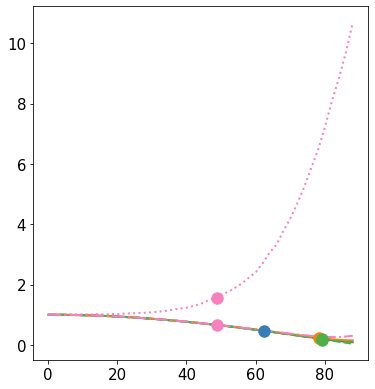

In [25]:
plt.figure(figsize=(6,6.5))
res.ID = res.ID.astype(str)

for col in esti2:

    if "a" in col:
        print(col)
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "a")]
        suff = " (I)"
    elif "b" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "b")]
        suff = " (II)"
      
    else:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "")]
        suff = ""
    c = _.iloc[0].color
    l = _.iloc[0].linestyle
    lab = str(props[props.ID == int(_.ID)].iloc[0].prefix) + " " +  _.iloc[0].ID[:3] + suff
    plt.plot(esti2.index, esti2[col], color =c, label=lab, linestyle=l, linewidth=2, zorder=-4)
    I = np.argmin(np.abs(esti2.index.values - _.iloc[0].latitude_deg_50))
    en = esti2.loc[esti2.index[I], str(col)]
    print(col, en, _.latitude_deg_50.values)
    print( esti2.loc[esti2.index[I], str(col)])
    plt.scatter(x=_.latitude_deg_50, y=en, c=c, s=130, alpha=1.)#label=lab)

    

plt.fill_between(simdf2.index, simdf2[.15],simdf2[60.], color="c", alpha=.4, label="simulated", zorder=-1)    
plt.legend(frameon=False, fontsize=12)
plt.xlim(0.1,88.)
#plt.ylim(0.,2.5)
plt.yscale("log")
plt.tight_layout()
# plt.ylabel(r"$ED$ [s]", fontsize=14)
#plt.ylabel(r"$E_\mathrm{flare}$ [erg]", fontsize=14)
plt.ylabel(r"relative energy emitted toward planet", fontsize=14)

plt.xlabel(r"flare latitude $\theta_f$ [deg]", fontsize=14);

452922110 0.4705719277932591 [62.89037605]
0.4709940235013759
277539431 0.2124993027164834 [78.33529523]
0.23591090025551747
237880881b 0.5598427599911403 [55.89816816]
0.5673086038121273
44984200b 0.17959234273440738 [79.16187451]
0.17284860835264498


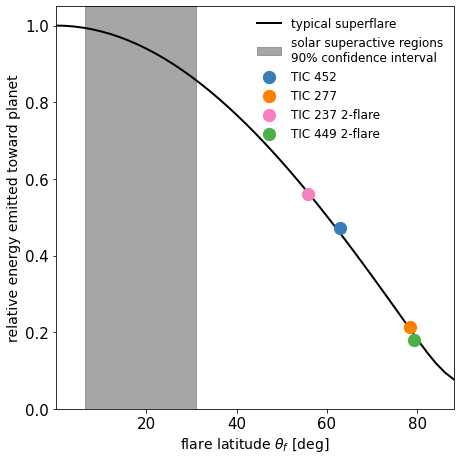

In [43]:
plt.figure(figsize=(6.5,6.5))
res.ID = res.ID.astype(str)
#esti2 = esti2.drop("100004076", axis=1)
for col in esti2:
    if "a" in col:
        continue
    elif "b" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "b")]
        suff = " 2-flare"
        
      
    else:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "")]
        suff = ""
    
    c = _.iloc[0].color
    l = _.iloc[0].linestyle
    lab = str(props[props.ID == int(_.ID)].iloc[0].prefix) + " " +  _.iloc[0].ID[:3] + suff
    
    I = np.argmin(np.abs(esti2.index.values - _.iloc[0].latitude_deg_50))
    en = esti2.loc[esti2.index[I], str("44984200a")]
    print(col, en, _.latitude_deg_50.values)
    print( esti2.loc[esti2.index[I], str(col)])
    if col == "44984200a":
        c = "orange"
    plt.scatter(x=_.latitude_deg_50, y=en, c=c, s=150, alpha=1.,label=lab)

    
plt.plot(esti2.index, esti2["44984200a"], color ="k", label="typical superflare", linestyle="solid", linewidth=2, zorder=-4)

plt.axvspan(6.4, 31., color="grey", zorder=-20, alpha=0.7, label="solar superactive regions\n90% confidence interval")
plt.legend(frameon=False, fontsize=12, loc=1)
plt.xlim(0.1,88.)
plt.ylim(0.,1.05)
#plt.yscale("log")
plt.tight_layout()
# plt.ylabel(r"$ED$ [s]", fontsize=14)
#plt.ylabel(r"$E_\mathrm{flare}$ [erg]", fontsize=14)
plt.ylabel(r"relative energy emitted toward planet", fontsize=14)

plt.xlabel(r"flare latitude $\theta_f$ [deg]", fontsize=14)
plt.tight_layout()
plt.savefig(f"/home/ekaterina/Documents/002_writing/multiperiod-flares-draft/"
            f"nature/multiperiodflaresnature/figures/06_11_2020_solar_comparison.png",
           dpi=300);

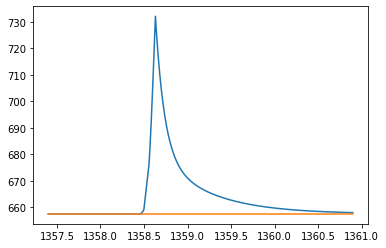

In [84]:
plt.plot(flc.time, flc.detrended_flux)
plt.plot(flc.time, flc.it_med)

In [85]:
equivalent_duration(flc,0,-4)

2868.7908427679163

In [54]:
len(time)

891

In [109]:
row.ID

'100004076'

# Inclinations from Elisabeth

In [11]:
incl = pd.read_csv(f"{CWD}/data/inclinations/inclination_output.dat", delimiter=r"\s+")
incl

,prefix,id,inclination,inclination_lowerr,inclination_uperr
0,KIC100004076,58.702743,-14.325956,17.799433,NaN
1,TIC237880881,22.278168,-3.993050,3.945734,NaN
2,TIC44984200,33.130091,-0.831807,0.882270,NaN
3,TIC277539431,83.029951,-6.038076,4.910168,NaN
4,TIC452922110,49.327840,-3.186934,3.520259,NaN


In [31]:
2.1e34/5e32

42.00000000000001